# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нам нужно обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Требуется модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import (train_test_split,
                                    GridSearchCV)
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score

from pymystem3 import Mystem
from tqdm import notebook

import spacy

In [2]:
# константы
RANDOM_STATE = 12345

# словарь слова без смысловой нагрузки
nltk.download('stopwords')
stopwords1 = set(nltk_stopwords.words('english'))
STOPWORDS=list(stopwords1)

# метрика расчитываемая при кросс-валидации
SCORER = 'f1'

# инициализируйте пространственную модель 'en_core_web_sm',
# сохранив только компонент теггера, необходимый для лемматизац
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Константин\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
try:
    toxic_comments_data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    toxic_comments_data = (pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\Модуль 3\\Машинное обучение для текстов\\toxic_comments.csv'))

In [4]:
# функция для вывода основной информации о данных
def data_research1(data):
    display(data.head())
    print()
    data.info()
    print()
    print('Пропуски:', data.isna().sum().sum(), 'это {:.2%} от всех данных.'
          .format(data.isna().sum().sum() / (data.shape[0] * data.shape[1])))
    print()
    print('Процент (%) пропусков в каждой категории данных.')
    display((data.isna().sum() / data.shape[0]) * 100)
    print()
    print('Явные дубликаты:', data.duplicated().sum(), 'это {:.2%} от всех данных.'
          .format(data.duplicated().sum() / data.shape[0]))
    
    # строим график распределения 
    data.hist(bins=100,figsize=(30, 10))

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB

Пропуски: 0 это 0.00% от всех данных.

Процент (%) пропусков в каждой категории данных.


Unnamed: 0    0.0
text          0.0
toxic         0.0
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.


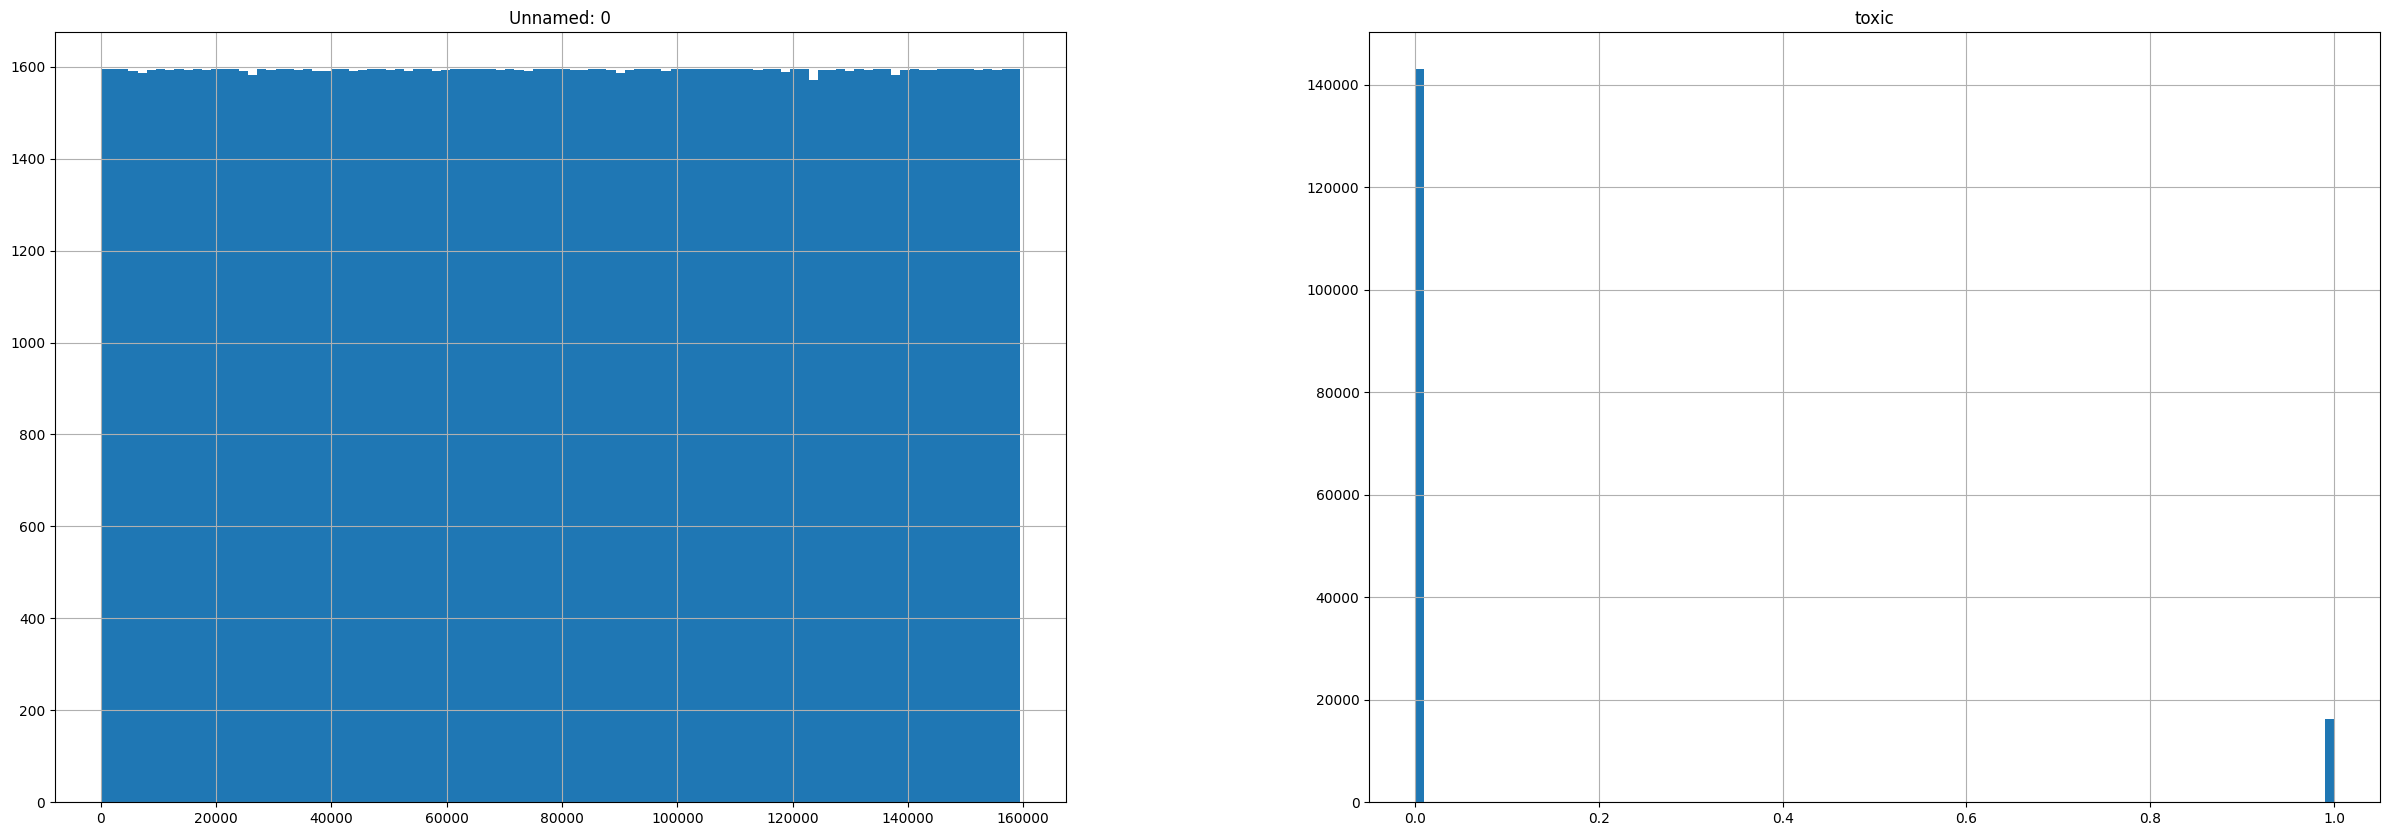

In [5]:
data_research1(toxic_comments_data)

В данных отсутствуют дубликаты и пропуски, но имеется столбец с копией индексов и дисбаланс целевого признака. Будем устранять.

In [6]:
# удаление столбца
toxic_comments = (toxic_comments_data.copy(deep=True)                                
                  .drop(['Unnamed: 0'], axis=1))

In [7]:
# изменение типа данных
toxic_comments['toxic'] = toxic_comments['toxic'].astype('int8')

Очистим от лишних символов и приведение слова к начальной форме.

In [10]:
print(toxic_comments['text'][0])
toxic_comments.head()

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [15]:
# функция лемматизации
def lemmatization(text):   
    # анализ предложения, используя загруженный объект модели 'en_core_web_sm' `nlp`
    doc = nlp(text)
    # извлечение леммы для каждого токена
    text_clean =  " ".join([token.lemma_ for token in doc])
    # удаление всех символов  кроме букв латинского алфавита и привидение символов к одному регистру
    text_clean_2 = re.sub(r'[^a-zA-Z]', ' ', text_clean).lower()
    # удаление лишних пробелов
    return " ".join(text_clean_2.split())

In [16]:
# лемматизации текста в данных
notebook.tqdm.pandas()
toxic_comments['text']= toxic_comments['text'].progress_apply(lemmatization)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [17]:
print(toxic_comments['text'][0])
toxic_comments.head()

explanation why the edit make under my username hardcore metallica fan be revert they be not vandalism just closure on some gas after i vote at new york dolls fac and please do not remove the template from the talk page since i be retire now


,text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour i be see...,0
2,hey man i be really not try to edit war it be ...,0
3,more i can not make any real suggestion on imp...,0
4,you sir be my hero any chance you remember wha...,0


0    0.898388
1    0.101612
Name: toxic, dtype: float64


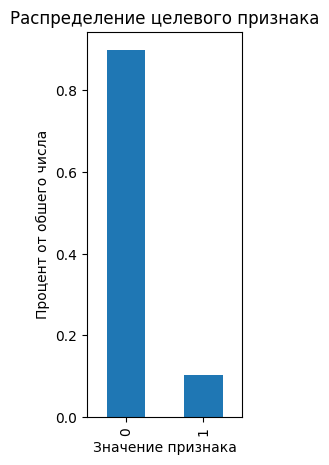

In [18]:
# обзор соотношения классов до балансировки в данных
class_frequency = toxic_comments['toxic'].value_counts(normalize=True)
print(class_frequency)
plt.figure(figsize=(2, 5))
class_frequency.plot(kind='bar')
plt.xlabel('Значение признака')
plt.ylabel('Процент от обшего числа')
plt.title('Распределение целевого признака')
plt.show()

In [68]:
# функция выполняет:
# разделения данных на обучающую, валидационную и тестовую выборки
# балансировку классов в обучающей выборке
# вычисление TF-IDF
def matrix_of_values(data, fraction, repeat):
            
    features = data.drop('toxic', axis=1)
    target = data['toxic']
    
    # разделяем выборки в пропорции 60 20 20
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                  test_size=0.4, 
                                                                                  random_state=RANDOM_STATE,
                                                                                  stratify=target)
    
    features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=RANDOM_STATE,
                                                     stratify=target_valid)
    
    # уменьшение отрицательного признака в обучающей выборке
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    features_train = pd.concat(
    [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
    
    target_train = pd.concat(
    [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])
    
    # увеличение положительного признака в обучающей выборке
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    features_train = pd.concat([features_zeros] + [features_ones] * repeat)
    target_train = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # cоздание матрици cо значениями TF-IDF по корпусу
    tf_idf = TfidfVectorizer(stop_words=STOPWORDS)
    
    tf_idf_model = tf_idf.fit(features_train['text'])
    
    features_train_tfidf = tf_idf_model.transform(features_train['text'])
    features_valid_tfidf = tf_idf_model.transform(features_valid['text'])
    features_test_tfidf = tf_idf_model.transform(features_test['text'])


    
    return features_train_tfidf, features_valid_tfidf, features_test_tfidf, target_train, target_valid, target_test 

Уменьшу количество данных, чтобы не сильно много время уходило на обучение моделей.

In [120]:
features_train_tfidf, features_valid_tfidf, features_test_tfidf, target_train, target_valid, target_test = matrix_of_values(toxic_comments, 0.55, 5)

In [121]:
print(features_train_tfidf.shape)
print(features_valid_tfidf.shape)
print(features_test_tfidf.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(95785, 83866)
(31858, 83866)
(31859, 83866)
(95785,)
(31858,)
(31859,)


1    0.506969
0    0.493031
Name: toxic, dtype: float64


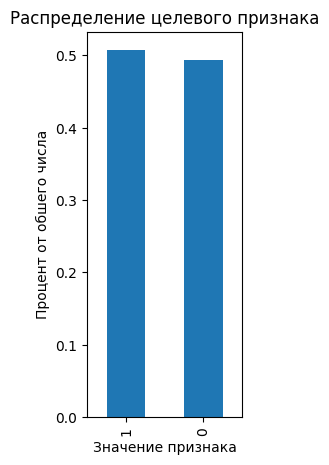

In [122]:
# обзор соотношения классов после балансировки в обучающей выборке
class_repeat = target_train.value_counts(normalize=True)
print(class_repeat)
plt.figure(figsize=(2, 5))
class_repeat.plot(kind='bar')
plt.xlabel('Значение признака')
plt.ylabel('Процент от обшего числа')
plt.title('Распределение целевого признака')
plt.show()

0    0.898396
1    0.101604
Name: toxic, dtype: float64


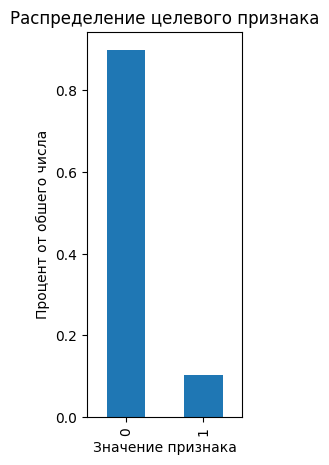

In [123]:
# обзор соотношения классов после балансировки в тестовой выборке
class_repeat = target_test.value_counts(normalize=True)
print(class_repeat)
plt.figure(figsize=(2, 5))
class_repeat.plot(kind='bar')
plt.xlabel('Значение признака')
plt.ylabel('Процент от обшего числа')
plt.title('Распределение целевого признака')
plt.show()

Данные переведены в векторный вид для вычислений и сбалансированы.

## Обучение

Обучим 3 модели.

In [124]:
# таблица для сбора показателей моделей
table_1 = pd.DataFrame({'Модель': [], 'F1': [], 'Параметры модли': []})

In [125]:
%%time
# создание моди
model_1=LogisticRegression(random_state=RANDOM_STATE)
# гиперпараметры для обучение
parameters={}
# рассчет F1 при кросс-валидации
tuning_model_1=GridSearchCV(model_1,param_grid=parameters,scoring=SCORER)
tuning_model_1.fit(features_train_tfidf, target_train)

# добавление данные в таблицу 
name = 'LinearRegression'
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(tuning_model_1.best_score_),
                                     tuning_model_1.best_params_
                                    ]

# вывод данных о модели
table_1

C:\Users\Константин\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Константин\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Wall time: 8.62 s


,Модель,F1,Параметры модли
0,LinearRegression,0.95,{}


In [126]:
%%time
# создание моди
model_2=RandomForestClassifier(random_state=RANDOM_STATE)
# гиперпараметры для обучение
parameters={'n_estimators': range (1, 101, 10),
            'max_depth' : range (1, 16, 3),
            'max_features':['sqrt']
           }
# рассчет F1 при кросс-валидации
tuning_model_2=GridSearchCV(model_2,param_grid=parameters,scoring=SCORER)
tuning_model_2.fit(features_train_tfidf, target_train)

# добавление данные в таблицу 
name = 'RandomForestClassifier'
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(tuning_model_2.best_score_),
                                     tuning_model_2.best_params_
                                    ]

# вывод данных о модели
table_1

Wall time: 15min 12s


,Модель,F1,Параметры модли
0,LinearRegression,0.95,{}
1,RandomForestClassifier,0.81,"{'max_depth': 13, 'max_features': 'sqrt', 'n_e..."


In [127]:
%%time
# создание моди
model_3=LGBMClassifier(random_state=RANDOM_STATE)
# гиперпараметры для обучение
parameters={'n_estimators' : range (50, 201, 50),
            'num_leaves' : range (20, 101, 20)
           }
# рассчет F1 при кросс-валидации
tuning_model_3=GridSearchCV(model_3,param_grid=parameters,scoring=SCORER)
tuning_model_3.fit(features_train_tfidf, target_train)

# добавление данные в таблицу 
name = 'LGBMClassifier'
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(tuning_model_3.best_score_),
                                     tuning_model_3.best_params_
                                    ]

# вывод данных о модели
table_1

Wall time: 15min 21s


,Модель,F1,Параметры модли
0,LinearRegression,0.95,{}
1,RandomForestClassifier,0.81,"{'max_depth': 13, 'max_features': 'sqrt', 'n_e..."
2,LGBMClassifier,0.98,"{'n_estimators': 200, 'num_leaves': 100}"


Было обучено 3 модели. Лучшие показатели у LGBMClassifier.

## Выводы

In [128]:
# рассчитаем финальное F1 для тестовой выборки на лучшей модели
predictions = tuning_model_3.predict(features_test_tfidf)
f1 = f1_score(target_test, predictions)
name = 'BestModelTest'
# перенос данных из лучшей модели 
best_params = tuning_model_3.best_params_
# добавление данные в таблицу 
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(f1),
                                     best_params
                                    ]

# вывод данных о модели
table_1

,Модель,F1,Параметры модли
0,LinearRegression,0.95,{}
1,RandomForestClassifier,0.81,"{'max_depth': 13, 'max_features': 'sqrt', 'n_e..."
2,LGBMClassifier,0.98,"{'n_estimators': 200, 'num_leaves': 100}"
3,BestModelTest,0.76,"{'n_estimators': 200, 'num_leaves': 100}"


In [129]:
# рассчитаем финальное F1 для тестовой выборки на проверочной модели
dummy_model = DummyClassifier(random_state=RANDOM_STATE, strategy = 'uniform')
dummy_model.fit(features_train_tfidf, target_train)

dummy_test_predictions = dummy_model.predict(features_test_tfidf)

f1 = f1_score(target_test, dummy_test_predictions)
name = 'DummyRegressor'
# добавление данные в таблицу 
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(f1),
                                     best_params
                                    ]

# вывод данных о модели
table_1

,Модель,F1,Параметры модли
0,LinearRegression,0.95,{}
1,RandomForestClassifier,0.81,"{'max_depth': 13, 'max_features': 'sqrt', 'n_e..."
2,LGBMClassifier,0.98,"{'n_estimators': 200, 'num_leaves': 100}"
3,BestModelTest,0.76,"{'n_estimators': 200, 'num_leaves': 100}"
4,DummyRegressor,0.17,"{'n_estimators': 200, 'num_leaves': 100}"


**Вывод**
- В данных не имеют пропусков и дубликатов.
- Данные были преобразованы и сбалансированны.
- Произведена обработка данных. Выполнено обучение 3 моделей и сбор параметров их работы на основе которых выбрана лучшая LGBMClassifier. 
- Произведено сравнение результатов LGBMClassifier и DummyClassifier на тестовой выборке. Модель адекватна и показывает требуемую точность установленной метрики. 
- Рекомендую LGBMClassifier для использования в качестве модели поиска токсичных комментариев.